Proposed CNN network

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
import csv
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


Function to parse the dataset into image and label

In [4]:
def load_data(file):
  train_image = []
  train_label = []
  train_categories = {}

  with open(file) as train_data:
    data = csv.reader(train_data)
    next(data)

    for line in data:
      pixel_str = line[1]
      pixel_list = pixel_str.split()
      pixel_list = np.array(pixel_list,dtype='uint8')
      image= pixel_list.reshape((48,48))
      train_image.append(image)

      label = line[0]
      train_label.append(int(label))

      c = 1
      if label in train_categories:
        c = train_categories[label] + 1
      train_categories[label] = c

    x = np.array(train_image)
    y = np.array(train_label)
    #print(np.shape(x))
    #print(np.shape(y))
    
    return x,y


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Text(0.5, 1.0, '3')

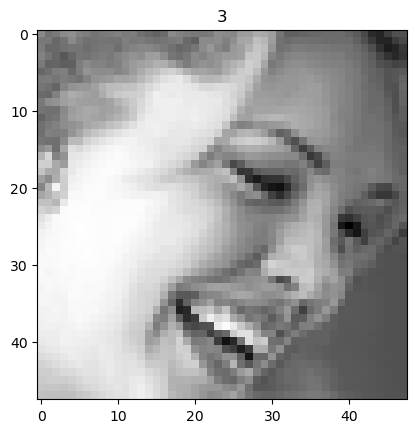

In [5]:
file = 'train.csv'
image,label = load_data(file)
i = np.random.randint(len(image))
plt.imshow(image[i], cmap = 'gray')
plt.title(label[i])

To make a custom dataset in Pytorch using image and label and applying transformation for data augmentation in addition to convert to Tensor

In [6]:
class FERdataset(Dataset):
  def __init__(self,image,label,transform):
    self.image = image
    self.label = label
    self.transform = transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image = self.image[index].reshape(48,48)
    image = Image.fromarray((image))
    #if self.transfrom is not None:
    image = self.transform(image)
    label = self.label[index]
    return image, label

Function to create the dataloaders

In [7]:
def dataLoaders(image,label,batch_sz_train, batch_sz_val):

  X_train,X_val,Y_train, Y_val = train_test_split(image,label,test_size=0.2,random_state=1)

  train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  val_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  
  train_data = FERdataset(X_train,Y_train,train_transform)
  val_data = FERdataset(X_val,Y_val,val_transform)

  train_loader = DataLoader(train_data, batch_size=batch_sz_train, shuffle=True)
  val_loader = DataLoader(val_data,batch_size=batch_sz_val,shuffle=True)

  
  return train_loader,val_loader


Checking the dataloaders on train data

In [8]:
image,label = load_data(file)
tr,val = dataLoaders(image,label,4000,1000)
print(len(tr.dataset))

22967


Defining the architecture

In [9]:
class vgg(nn.Module):
  def __init__(self):
    super(vgg,self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU())
    self.layer2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(64),
                                nn.Dropout2d(p=0.3),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.ReLU())
    self.layer3 = nn.Sequential(nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU())
    self.layer4 = nn.Sequential(nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(128),
                                nn.Dropout2d(p=0.3),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.ReLU())
    self.layer5 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU())
    self.layer6 = nn.Sequential(nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU())
    self.layer7 = nn.Sequential(nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(256),
                                nn.Dropout2d(p=0.3),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.ReLU())
    self.layer8 = nn.Sequential(nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU())
    self.layer9 = nn.Sequential(nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU())
    self.layer10 = nn.Sequential(nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU())
    self.layer11 = nn.Sequential(nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                                nn.BatchNorm2d(512),
                                nn.Dropout2d(p=0.3),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.ReLU())
    self.fc1 = nn.Sequential(nn.Dropout(p=0.5),
                             nn.Linear(3*3*512,4096),
                             nn.ReLU())
    self.fc2 = nn.Sequential(nn.Dropout(p=0.5),
                             nn.Linear(4096,2048),
                             nn.ReLU())
    self.fc3 = nn.Sequential(nn.Linear(2048,7),
                             nn.LogSoftmax(dim=1))

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.layer6(x)
    x = self.layer7(x)
    x = self.layer8(x)
    x = self.layer9(x)
    x = self.layer10(x)
    x = self.layer11(x)
    x = x.view(-1,4608)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x


  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)


Function to train the model

In [10]:
def train_network(model, train_loader, val_loader, epoch, device):
  #optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9,0.999),
   #                      eps=1e-08, weight_decay=0.001)
  optimizer = optim.Adamax(model.parameters(),lr=learning_rate)
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
    
  for e in range(epoch):
    model.train()
    tr_loss = 0
    tr_correct = 0
    val_loss = 0
    val_correct = 0

    #training the network with train images
    for i,(image,label) in enumerate(train_loader):

      image = image.to(device)
      label = label.to(device)

      #Forward pass
      output = model(image)
      loss = F.nll_loss(output,label)

      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tr_loss += loss.item() 
      _,pred = torch.max(output,1)
      tr_correct += torch.sum(pred==label.data)
      

    #validating the network with validation images
    model.eval()
    with torch.no_grad():
      for i,(image,label) in enumerate(val_loader):
        image = image.to(device)
        label = label.to(device)
        output = model(image)

        lossVal = F.nll_loss(output,label)
        val_loss += lossVal.item()
        _,pred = torch.max(output,1)
        val_correct +=torch.sum(pred==label.data)

    train_losses.append(tr_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracy = tr_correct*100.0/len(train_loader.dataset)
    val_accuracy = val_correct*100.0/len(val_loader.dataset)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Epoch: {e+1}/{epoch}, Training Loss: {train_losses[-1]:.3f}, Training Accuracy: {train_accuracy:.3f}% Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracy:.3f}%')

  plt.subplot(2,1,1)
  plt.plot(train_losses,'r',label='Training loss')
  plt.plot(val_losses,'g',label='validation loss')
  plt.legend(['Train loss','Validation loss'])
  #plt.xlabel('Number of epoch trained')
  plt.ylabel('Loss')
  plt.subplot(2,1,2)
  plt.plot(torch.tensor(train_accuracies).cpu().numpy(),'r',label='Training accuracy')
  plt.plot(torch.tensor(val_accuracies).cpu().numpy(),'g',label='validation accuracy')
  plt.legend(['Train accuracy','Validation accuracy'])
  plt.xlabel('Number of epoch trained')
  plt.ylabel('Accuracy')   
  plt.show()

  torch.save(model.state_dict(),'vggModel1.pth')


Hyperparameters

In [11]:
num_epoch = 100
learning_rate = 0.001
train_batchSize = 64
val_batchSize = 64

Epoch: 1/100, Training Loss: 1.863, Training Accuracy: 24.452% Val Loss: 1.797, Val Accuracy: 25.636%
Epoch: 2/100, Training Loss: 1.811, Training Accuracy: 24.648% Val Loss: 1.784, Val Accuracy: 25.636%
Epoch: 3/100, Training Loss: 1.800, Training Accuracy: 24.740% Val Loss: 1.777, Val Accuracy: 25.636%
Epoch: 4/100, Training Loss: 1.792, Training Accuracy: 25.093% Val Loss: 1.776, Val Accuracy: 25.740%
Epoch: 5/100, Training Loss: 1.780, Training Accuracy: 26.168% Val Loss: 1.732, Val Accuracy: 29.293%
Epoch: 6/100, Training Loss: 1.716, Training Accuracy: 29.982% Val Loss: 1.560, Val Accuracy: 38.924%
Epoch: 7/100, Training Loss: 1.592, Training Accuracy: 37.075% Val Loss: 1.430, Val Accuracy: 43.678%
Epoch: 8/100, Training Loss: 1.517, Training Accuracy: 40.811% Val Loss: 1.412, Val Accuracy: 45.925%
Epoch: 9/100, Training Loss: 1.456, Training Accuracy: 43.171% Val Loss: 1.322, Val Accuracy: 49.843%
Epoch: 10/100, Training Loss: 1.405, Training Accuracy: 45.591% Val Loss: 1.266, V

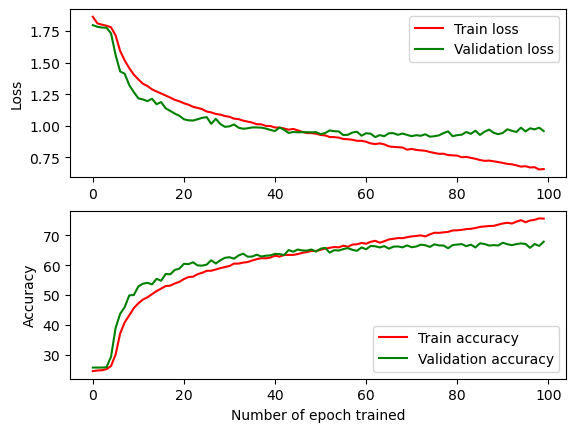

In [12]:
image,label = load_data(file)
tr_Dataloader,val_Dataloader = dataLoaders(image,label,train_batchSize,val_batchSize)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vgg()
model.to(device)
train_network(model,tr_Dataloader,val_Dataloader,epoch=num_epoch,device=device)

In [13]:
filename = 'vggModel1.pth'

In [14]:
trained_network = vgg()
trained_network.load_state_dict(torch.load(filename))

<All keys matched successfully>

Function to test the trained network

In [15]:
def test_network(vgg,data_loader):
    # Test the model
    vgg.eval()

    test_loss = 0
    correct = 0
    losses = []
    
    trueLabel = []
    predLabel = []
    
    # Preventing gradient calculation
    with torch.no_grad():
        for image,label in data_loader:
            image = image.to(device)
            label = label.to(device)
            pred = vgg(image)
            test_loss += F.nll_loss(pred,label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
            trueLabel +=label.cpu().numpy().tolist()
            predLabel +=pred.argmax(1).cpu().numpy().tolist()
    test_loss /= len(data_loader)
    losses.append(test_loss)
    correct /= len(data_loader.dataset)
    accuracy = correct*100.
    print(f'Test set: Accuracy: {correct*100.:.2f}% Loss: {test_loss:.6f}')
    return trueLabel,predLabel

In [16]:
def testDataLoaders(image,label,batch_size):

  test_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  
  test_data = FERdataset(image,label,test_transform)

  test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

  return test_loader

In [17]:
testFile = 'test.csv'
testImage,testLabel = load_data(testFile)
test_data_loader = testDataLoaders(testImage,testLabel,100)
print(len(test_data_loader.dataset))

7178


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_network.to(device)
trueLabel,predLabel = test_network(vgg=trained_network,data_loader=test_data_loader)

Test set: Accuracy: 66.86% Loss: 0.978408


Evaluating the performance of CNN

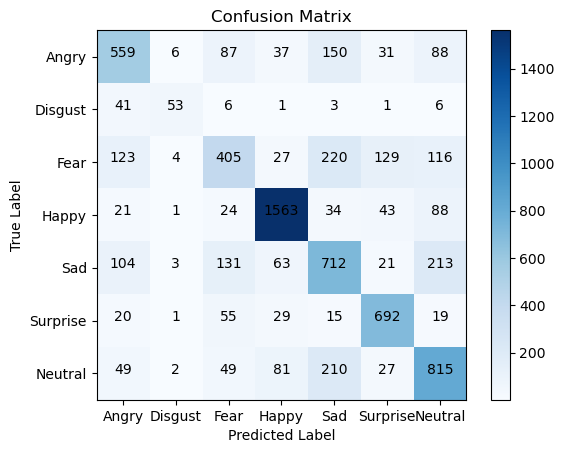

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(trueLabel, predLabel)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.xticks(range(len(labels)),labels)
plt.yticks(range(len(labels)),labels)
for i,j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment='center',color='black')
plt.show()

Precision,Recall and F1 score

In [20]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

precision = np.round(precision,2)
recall = np.round(recall,2)
f1_score = np.round(f1_score,2)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Precision: [0.61 0.76 0.54 0.87 0.53 0.73 0.61]
Recall: [0.58 0.48 0.4  0.88 0.57 0.83 0.66]
F1 Score: [0.6  0.59 0.45 0.87 0.55 0.78 0.63]
